In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from dataset import get_dataset
import torchvision
import numpy as np
from arch import DQN_Conv

# Tải mô hình đơn giản (ví dụ: ResNet)
from arch import CONV_MNIST

# 1. Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tải mô hình đã huấn luyện trước
model = CONV_MNIST()
model.load_state_dict(torch.load('trained_model/mnist_cnn_best.pth'))

model.eval().to(device)  # Đặt chế độ đánh giá (evaluation mode)

# 3. Định nghĩa FGSM Attack
def fgsm_attack(image, epsilon, gradient):
    # Lấy dấu của gradient
    sign_gradient = gradient.sign()
    # sign_gradient[sign_gradient] = 0
    # Tạo mẫu tấn công
    perturbed_image = image + epsilon * sign_gradient
    # Giới hạn giá trị pixel [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def fgsm_attack_2(image, epsilon, mask):
    # 14*14 -> 28*28
    fit_mask = torch.zeros(image.shape)
    for i in range(14):
        for j in range(14):
            fit_mask[0][0][i*2][j*2] = mask[i][j]
            fit_mask[0][0][i*2+1][j*2] = mask[i][j]
            fit_mask[0][0][i*2][j*2+1] = mask[i][j]
            fit_mask[0][0][i*2+1][j*2+1] = mask[i][j]
    # Tạo mẫu nhiễu
    perturbed_image = image + epsilon * fit_mask.to(device)
    # Giới hạn giá trị pixel [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 4. Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = get_dataset('mnist', split='train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 5. Tấn công mẫu đầu tiên
epsilon = 0.2  # Mức độ nhiễu
criterion = nn.CrossEntropyLoss()


dqn = DQN_Conv(28*28, 14*14)
dqn.load_state_dict(torch.load('model_0_trrenvong_2.pth'))
dqn.eval().to(device)


C:\Users\hokha\AppData\Local\Temp\ipykernel_4356\1345593191.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model/mnist_cnn_be

DQN_Conv(
  (classifier): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=196, bias=True)
  )
)

  0%|          | 0/60000 [00:00<?, ?it/s]

Distance FGSM: 4.159967422485352
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.315948724746704


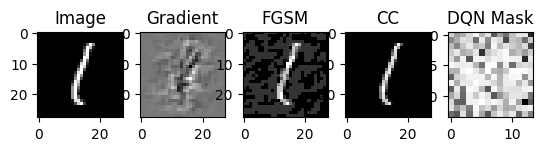

  0%|          | 1/60000 [00:00<4:15:59,  3.91it/s]

Distance FGSM: 4.185546875
Label gốc: 4, FGSM: 8
CC: 4
Distance CC: 1.0508861541748047


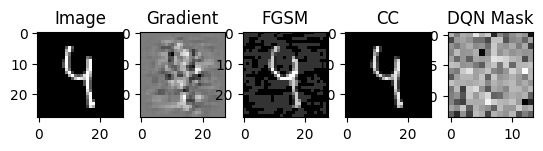

  0%|          | 2/60000 [00:00<5:07:27,  3.25it/s]

Distance FGSM: 4.080080986022949
Label gốc: 6, FGSM: 8
CC: 6
Distance CC: 1.5949283838272095


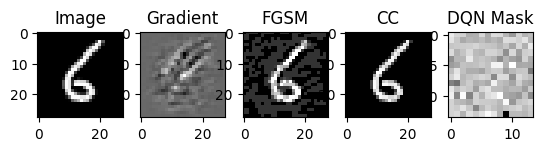

  0%|          | 3/60000 [00:00<5:16:01,  3.16it/s]

Distance FGSM: 3.9819858074188232
Label gốc: 1, FGSM: 8
CC: 1
Distance CC: 1.4134466648101807


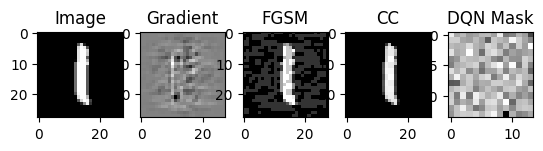

  0%|          | 4/60000 [00:01<5:22:52,  3.10it/s]

Distance FGSM: 4.043705940246582
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 2.0224475860595703


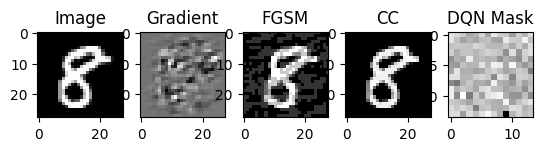

  0%|          | 5/60000 [00:01<7:03:51,  2.36it/s]

Distance FGSM: 4.077871322631836
Label gốc: 0, FGSM: 2
CC: 0
Distance CC: 2.452446222305298


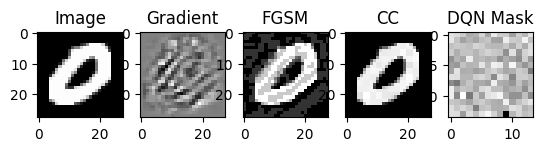

  0%|          | 6/60000 [00:02<6:36:18,  2.52it/s]

Distance FGSM: 3.9597980976104736
Label gốc: 4, FGSM: 4
CC: 4
Distance CC: 1.925037145614624


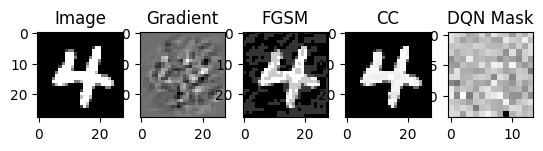

  0%|          | 7/60000 [00:02<6:05:41,  2.73it/s]

Distance FGSM: 4.207355499267578
Label gốc: 3, FGSM: 8
CC: 3
Distance CC: 1.8827202320098877


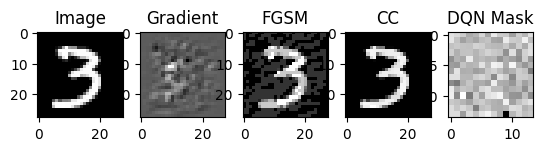

  0%|          | 8/60000 [00:02<5:48:22,  2.87it/s]

Distance FGSM: 4.135702610015869
Label gốc: 7, FGSM: 8
CC: 7
Distance CC: 1.5383861064910889


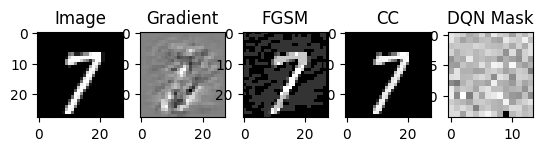

  0%|          | 9/60000 [00:03<5:19:33,  3.13it/s]

Distance FGSM: 4.091925144195557
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.5630481243133545


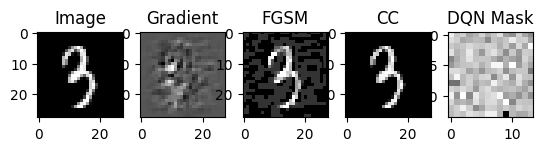

  0%|          | 10/60000 [00:03<5:00:58,  3.32it/s]

Distance FGSM: 4.253031253814697
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.9277743101119995


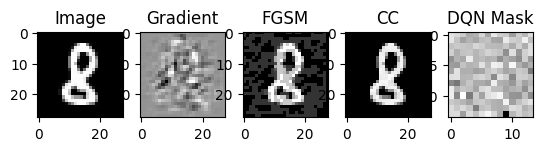

  0%|          | 11/60000 [00:03<4:46:34,  3.49it/s]

Distance FGSM: 3.780005693435669
Label gốc: 4, FGSM: 9
CC: 4
Distance CC: 1.8276876211166382


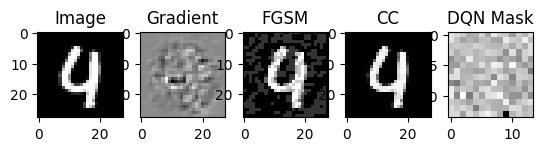

  0%|          | 12/60000 [00:03<4:36:48,  3.61it/s]

Distance FGSM: 4.004278659820557
Label gốc: 2, FGSM: 8
CC: 2
Distance CC: 1.7555179595947266


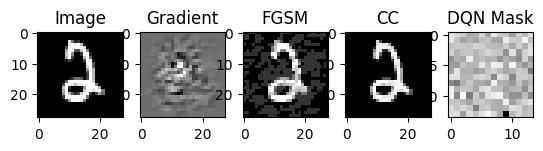

  0%|          | 13/60000 [00:04<5:50:53,  2.85it/s]

Distance FGSM: 4.1434783935546875
Label gốc: 9, FGSM: 8
CC: 8
Distance CC: 2.175123929977417


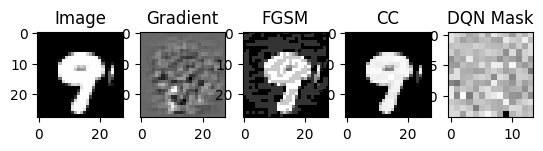

  0%|          | 14/60000 [00:04<5:31:21,  3.02it/s]

Distance FGSM: 4.242702484130859
Label gốc: 0, FGSM: 8
CC: 0
Distance CC: 2.231576681137085


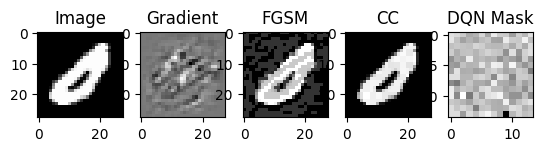

  0%|          | 15/60000 [00:04<5:29:13,  3.04it/s]

Distance FGSM: 4.0260725021362305
Label gốc: 6, FGSM: 8
CC: 6
Distance CC: 1.6749987602233887


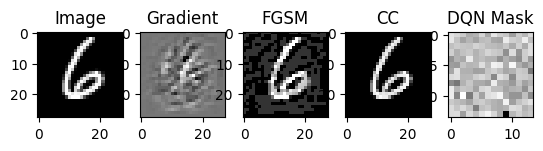

  0%|          | 16/60000 [00:05<5:07:35,  3.25it/s]

Distance FGSM: 4.1455078125
Label gốc: 1, FGSM: 8
CC: 1
Distance CC: 1.37656831741333


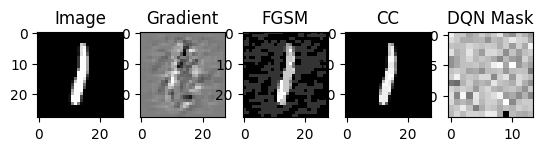

  0%|          | 17/60000 [00:05<4:52:34,  3.42it/s]

Distance FGSM: 4.248608589172363
Label gốc: 7, FGSM: 2
CC: 7
Distance CC: 1.791132926940918


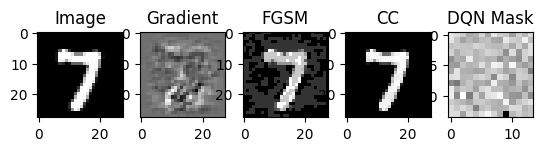

  0%|          | 18/60000 [00:05<4:58:22,  3.35it/s]

Distance FGSM: 3.9441566467285156
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.738802194595337


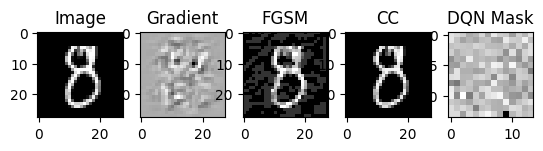

  0%|          | 19/60000 [00:06<4:47:42,  3.47it/s]

Distance FGSM: 4.179182052612305
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.6005020141601562


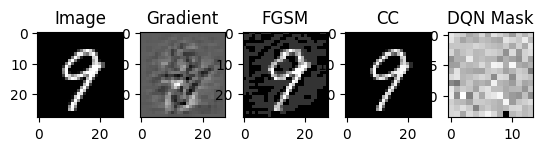

  0%|          | 20/60000 [00:06<4:49:46,  3.45it/s]

Distance FGSM: 4.316432476043701
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.8458986282348633


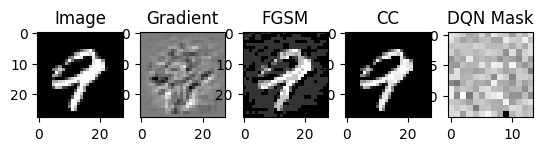

  0%|          | 21/60000 [00:07<6:41:31,  2.49it/s]

Distance FGSM: 3.979949712753296
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.9451615810394287


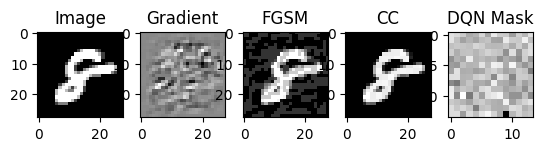

  0%|          | 22/60000 [00:07<6:12:54,  2.68it/s]

Distance FGSM: 4.064232349395752
Label gốc: 9, FGSM: 8
CC: 9
Distance CC: 1.4580785036087036


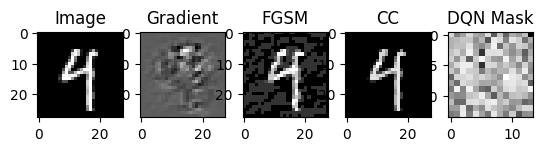

  0%|          | 23/60000 [00:07<5:46:28,  2.89it/s]

Distance FGSM: 4.272832870483398
Label gốc: 5, FGSM: 8
CC: 8
Distance CC: 1.7296212911605835


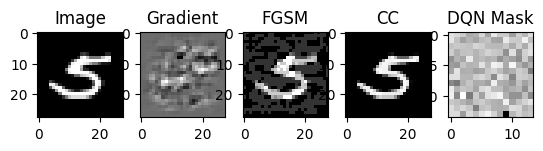

  0%|          | 24/60000 [00:07<5:26:47,  3.06it/s]

Distance FGSM: 4.294182300567627
Label gốc: 6, FGSM: 8
CC: 6
Distance CC: 1.5901660919189453


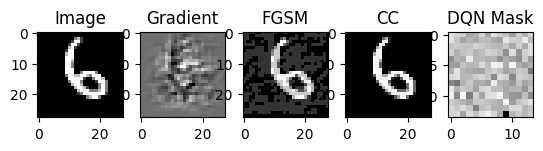

  0%|          | 25/60000 [00:08<5:02:10,  3.31it/s]

Distance FGSM: 4.061929702758789
Label gốc: 4, FGSM: 9
CC: 4
Distance CC: 1.5066405534744263


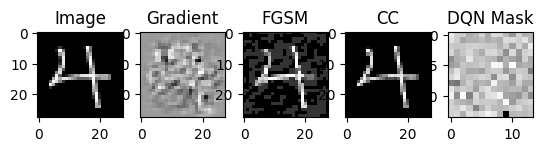

  0%|          | 26/60000 [00:08<4:57:20,  3.36it/s]

Distance FGSM: 4.088300704956055
Label gốc: 0, FGSM: 0
CC: 0
Distance CC: 2.0919041633605957


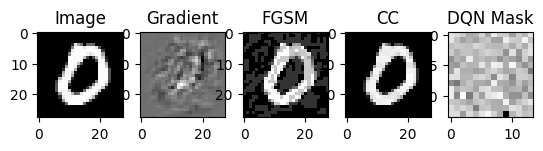

  0%|          | 27/60000 [00:08<5:03:33,  3.29it/s]

Distance FGSM: 4.03263521194458
Label gốc: 1, FGSM: 8
CC: 8
Distance CC: 1.1502126455307007


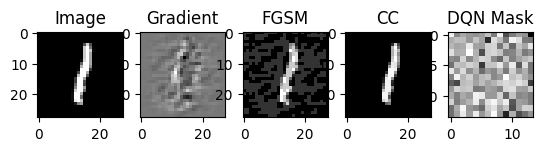

  0%|          | 28/60000 [00:09<4:51:15,  3.43it/s]

Distance FGSM: 4.047670364379883
Label gốc: 6, FGSM: 8
CC: 6
Distance CC: 1.7113735675811768


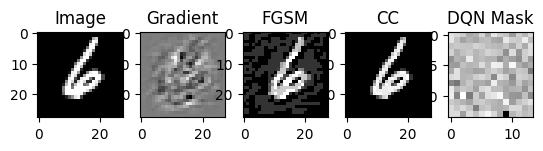

  0%|          | 29/60000 [00:09<5:49:40,  2.86it/s]

Distance FGSM: 4.185447692871094
Label gốc: 8, FGSM: 8
CC: 8
Distance CC: 1.7456822395324707


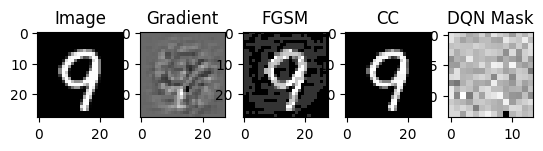

  0%|          | 29/60000 [00:09<5:37:42,  2.96it/s]


In [21]:

t = 30

from tqdm import tqdm

total = 0
correct = 0

for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)

    img_2_channel = torch.concatenate((images, images), 1)
    dqn_predict = dqn(img_2_channel)
    predict = dqn_predict.argmax(1)

    dqn_img = dqn_predict.view(14, 14).detach().cpu().numpy()
    #normalize
    dqn_img = (dqn_img - dqn_img.min()) / (dqn_img.max() - dqn_img.min())
    # 1 if > 0 else 0
    # dqn_img = np.where(dqn_img > 0, 1, 0)


    # print(f"Predict: {dqn_img}")
    # dqn_img = np.zeros((14, 14))
    # dqn_img[predict//14, predict%14] = 1
    
    # Đặt chế độ tính gradient
    images.requires_grad = True
    
    # Dự đoán ban đầu
    outputs = model(images)

    start_label = outputs.argmax(1).item()

    loss = criterion(outputs, labels)
    
    # Tính gradient
    model.zero_grad()
    loss.backward()
    gradient = images.grad.data

    # grid_img = np.zeros((14, 14))
    # for i in range(14):
    #     for j in range(14):
    #         grid_img[i, j] = gradient[0, 0, i*2:(i+1)*2, j*2:(j+1)*2].mean().item()

    grid_img = gradient.view(28, 28).detach().cpu().numpy() 

    # Tạo mẫu nhiễu
    perturbed_image = fgsm_attack(images, epsilon, gradient)

    distance = torch.norm(perturbed_image - images)
    print(f"Distance FGSM: {distance}")
    
    # Kiểm tra dự đoán trên mẫu bị tấn công
    outputs_perturbed = model(perturbed_image)
    _, final_pred = outputs_perturbed.max(1)
    
    print(f"Label gốc: {start_label}, FGSM: {final_pred.item()}")

    attack2_image = fgsm_attack_2(images, epsilon, torch.tensor(dqn_img).float().to(device))
    outputs_perturbed2 = model(attack2_image)
    _, final_pred2 = outputs_perturbed2.max(1)
    print(f"CC: {final_pred2.item()}")
    distance2 = torch.norm(attack2_image - images)
    print(f"Distance CC: {distance2}")

    # Hiển thị mẫu gốc, grad và mẫu bị tấn công
    import matplotlib.pyplot as plt
    plt.figure()
    plt.subplot(151)
    plt.imshow(images.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title('Image')
    plt.subplot(152)
    plt.imshow(grid_img, cmap='gray')
    plt.title('Gradient')
    plt.subplot(153)
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('FGSM')
    plt.subplot(154)
    plt.imshow(attack2_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('CC')
    plt.subplot(155)
    plt.imshow(dqn_img, cmap='gray')
    plt.title('DQN Mask')


    plt.show()
    
    t -= 1
    if t == 0:
        break
    # total += 1
    # if start_label != final_pred2.item():
    #     correct += 1

    # print(f"Accuracy: {correct/total}")

# print(f"Accuracy: {correct/total}")